# SIG data exercise: stock price data

1) Predict volatility for the next month given the samples

2) Confidence in prediction

Let's start with importing the data into a dataframe and just getting familiar with it

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels as sm
import seaborn as sns

%matplotlib inline

In [2]:
df=pd.read_csv('./stockdata2.csv')
df.describe()

,day,a,b,c,d,e,f
count,98352.00000,98281.000000,98352.000000,98322.000000,98334.000000,98352.000000,96981.000000
mean,181.29732,363.767737,10.048836,69.428375,49.803747,47.727738,13.204838
std,104.61705,28.281333,3.332643,28.670322,4.539923,7.053875,2.404705
min,1.00000,0.000000,4.885000,33.807000,1.000000,38.550000,9.365000
25%,89.00000,341.785000,6.605000,45.330750,46.175000,42.040000,10.945000
50%,180.00000,357.915000,10.595000,50.960000,50.105000,45.410000,13.325000
75%,271.00000,387.890000,13.465000,101.895000,53.735000,51.350000,15.035000
max,362.00000,426.560000,15.335000,116.385000,62.137000,69.210000,18.815000


So the data appears to be grouped by day. Doing a quick glance at the data, full days seem to have 391 entries (between 9:30AM to 4:00PM) while weekends and holidays are empty. Let's do a few preliminary plots to get a feeling.

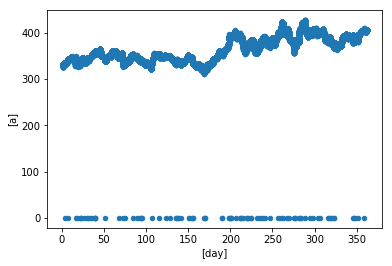

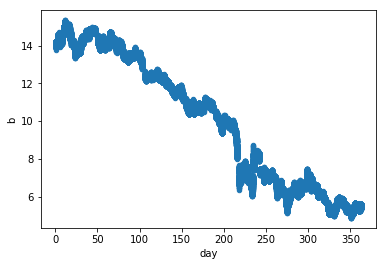

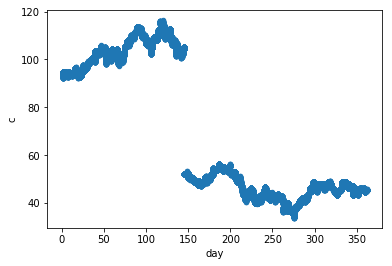

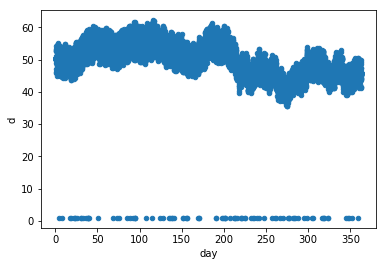

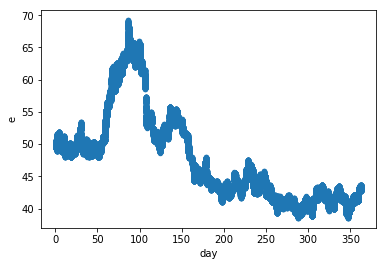

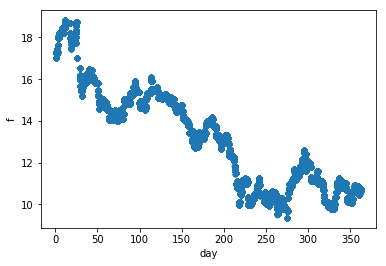

In [3]:
df.plot(x=['day'],y=['a'],kind='scatter')
df.plot(x='day',y='b',kind='scatter')
df.plot(x='day',y='c',kind='scatter')
df.plot(x='day',y='d',kind='scatter')
df.plot(x='day',y='e',kind='scatter')
df.plot(x='day',y='f',kind='scatter')

A few things to note: a major price shock in $c$ which is otherwise relatively stable, and a small, short-term bubble in the price of $e$. The day-to-day volatility of $d$ seems large compared to its longer-term volatility. Prices of $f$ are very illiquid and don't seem to move much minute to minute or even day to day. We also note that there are a few cases where stock a and stock d seem to drop precipitously, let's examine that:

In [4]:
print(len(df[df['a']==0]))
print(len(df[df['d']<10]))
df[(df['a']==0) & (df['d']<10)]
print("Mean number of days per month: "+str(len(df['day'].unique())/12))
print("Mean number of time points per day: "+str(len(df)/(12*21)))
for ii in df['day'].unique():
    if(len(df[df['day']==ii])!=391):
        print("Day "+str(ii)+" has "+str(len(df[df['day']==ii]))+" time points!")
        print(df[df['day']==ii].tail())


93
93
Mean number of days per month: 21.0
Mean number of time points per day: 390.2857142857143
Day 327 has 211 time points!
       day   timestr        a      b       c       d      e      f
88963  327  12:56:00  364.570  5.115  43.413  43.935  40.24  9.765
88964  327  12:57:00  364.700  5.115  43.405  43.875  40.24  9.765
88965  327  12:58:00  364.545  5.215  43.405  43.865  40.27  9.765
88966  327  12:59:00  364.380  5.125  43.325  43.855  40.33  9.765
88967  327  13:00:00  363.580  5.225  43.333  43.835  40.31  9.765


The times of the dips in stock $a$ are sporadic, seemingly unrelated times, on different days, and also correspond to the dips in stock $d$. Likely these dips are due to recording errors, and as a result this data is best cleaned via setting to NaN, since we plan to use the rolling window functionality of pandas. We note that stocks $b$ and $e$ have no null entries, no spurious dips, and are fully represented in the data set. In addition, we note that the data is conveniently divided up into 21 days per month, but there seem to be a day (327) that doesn't have the full number of time points where trading stops at 1pm

In [5]:
print(pd.isnull(df[['a','b','c','d','e','f']]).sum())

a      71
b       0
c      30
d      18
e       0
f    1371
dtype: int64


Let's now examine the nature of the null data in the other stocks on a daily basis and take a look at how many minutes out of each day does the data register as null:

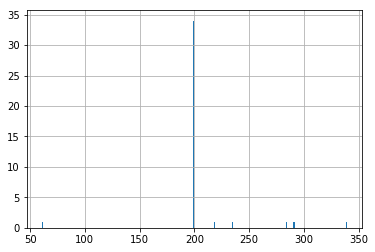

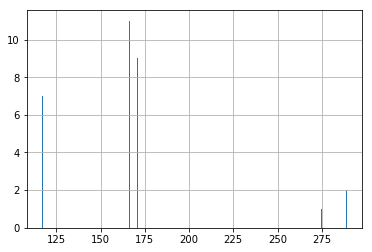

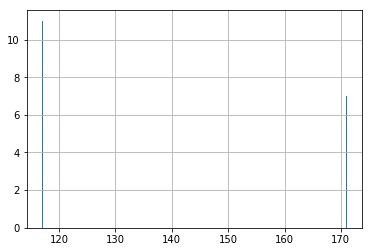

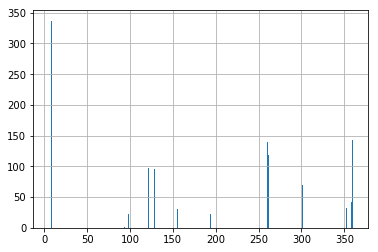

In [6]:
for ii in ['a','c','d','f']:
    df[pd.isnull(df[ii])]['day'].hist(bins=362)
    plt.show()

Most days are only missing a few minutes in a day , with the exception of stock $f$, which has several days in which at least a third of the data in a day is sometimes missing. Although it is very reasonable to perform simple interpolations for individual missing minutes, drawing a curve through large chunks of missing data will artificially and significantly affect volatility inference for that day. However, in the case of $f$ pricing, movements are so slow that in many cases replacing NaN values may be reasonable. Let's do the simple cleaning first: replacing spurious values in $a$ and $d$ as missing

In [7]:
df_clean=df.copy() #copy base data into new dataframe
#replace spurious prices -> missing
df_clean['a']=df['a'].replace(0,np.nan);
df_clean['d']=df['d'].replace(1.0,np.nan);

After cleaning the data, we want to look at log prices since we are going to explore volatility on log returns.

In [8]:
plist=list('abcdef')
logdf=np.log(df_clean[plist])
logdf['day']=df_clean['day'].copy()
logdf['timestr']=df_clean['timestr'].copy()
logdf=logdf[df_clean.columns.tolist()]

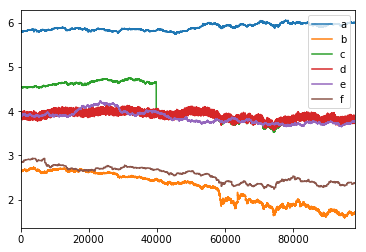

In [9]:
#plot log prices 
logdf.loc[:,'a':'f'].plot()

We see that the price of $d$ has high intra-day volatility despite having low monthly volatility. We consider a dataset that averages out the intra-day moves and see how it compares.

In [10]:
dayseries=df_clean['day'].unique();
logdf_day=pd.DataFrame({'day': dayseries,'a': dayseries,'b': dayseries,'c': dayseries,'d': dayseries,'e': dayseries,'f': dayseries})
logdf_day=logdf_day[['day','a','b','c','d','e','f']]
#creates daily averaged data
for idx,ii in enumerate(logdf_day['day']):
    logdf_day.iloc[idx,1:]=np.log(df_clean[df_clean['day']==ii].mean(axis=0))

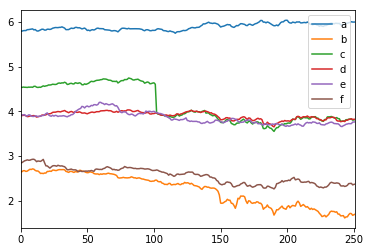

In [11]:
logdf_day.loc[:,'a':'f'].plot()

In principle, markets don't move when they are closed so we should be able to just concatenate the time-course data. But let's do a quick comparison between 1) general price moves, 2) overnight price moves, and 3) weekend price moves

In [12]:
df_diff=logdf[['day']+plist].diff(1)
normdiff=df_diff[df_diff['day']==0][plist]
daydiff=df_diff[df_diff['day']==1][plist]
enddiff=df_diff[df_diff['day']>1][plist]

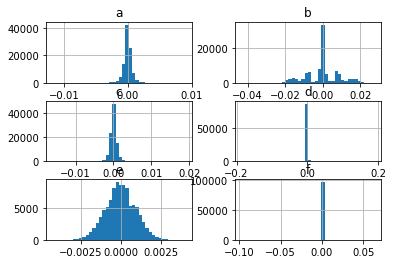

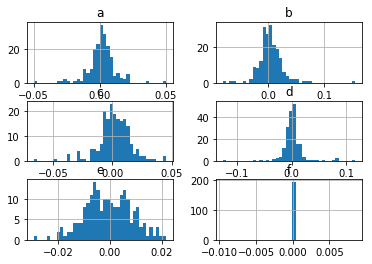

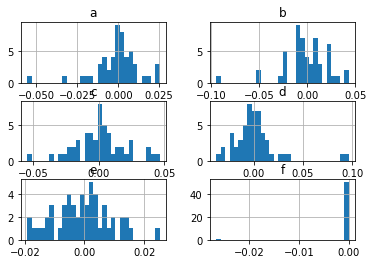

In [13]:
normdiff[normdiff['c']>-0.6].hist(bins=40);plt.show() #exclude massive mid-day drop in price of $c$
daydiff.hist(bins=40);plt.show()
enddiff.hist(bins=30);plt.show()

We see that for the most part between all the data sets, although daily price moves are quite different from overnight price moves, overnight and weekend price moves aren't all that different from each other. We can quantify this with p-values of the Kolmogorov-Smirnov 2-sample test, which is a bit more powerful than a paired t-test: it captures shape differences in the distribution and not just a single summary statistic. We observe that differences between minute moves and overnight as well as weekend moves are significant (except for $f$), while differences between overnight and weekend moves are not statistically significant. This is good: we don't have to worry about differentiating between overnight and weekend moves

In [14]:
ks_normday=pd.DataFrame(np.zeros([2,len(plist)]),columns=plist)
ks_normend=pd.DataFrame(np.zeros([2,len(plist)]),columns=plist)
ks_dayend=pd.DataFrame(np.zeros([2,len(plist)]),columns=plist)
for ii in plist:
    ks_normday[ii]=sp.stats.ks_2samp(normdiff[ii],daydiff[ii])
    ks_normend[ii]=sp.stats.ks_2samp(normdiff[ii],enddiff[ii])
    ks_dayend[ii]=sp.stats.ks_2samp(daydiff[ii],enddiff[ii])
print('Likelihood that minute and overnight moves drawn from same dist:')
print(ks_normday.iloc[1,:])
print('Likelihood that minute and weekend moves drawn from same dist:')
print(ks_normend.iloc[1,:])
print('Likelihood that overnight and weekend moves drawn from same dist:')
print(ks_dayend.iloc[1,:])

Likelihood that minute and overnight moves drawn from same dist:
a    2.504041e-48
b    2.618265e-12
c    3.341174e-41
d    4.360172e-28
e    1.444428e-35
f    1.000000e+00
Name: 1, dtype: float64
Likelihood that minute and weekend moves drawn from same dist:
a    8.146079e-10
b    4.911529e-03
c    3.121738e-10
d    2.044906e-09
e    2.041272e-09
f    1.000000e+00
Name: 1, dtype: float64
Likelihood that overnight and weekend moves drawn from same dist:
a    0.206434
b    0.513888
c    0.380714
d    0.367135
e    0.764701
f    1.000000
Name: 1, dtype: float64


This particular dataset which has averaged over the daily price moves is easy to compute the monthly log returns. We take a month to be 21 business days long and ignore weekends. Although in principle we could do windowed averages in accordance with days instead of business days, since the prices don't move when markets aren't open we go with the assumption that all market dynamics are properly captured by opening and closing of 

Now, to make predictions on monthly volatility there are a few basic considerations: different time windows to compute monthly volatility (utilizing a simple brownian walk model  $\sigma_{T} = \sigma_{t} \sqrt{T / t}$ to project into longer time windows -- in principle this could be extended to a broader class of walks with memory (Levy, fractional Brownian), but that would turn this exercise into a more extensive project); and memory functions of varying time-scales when regressing on past data.

For the purposes of this exercise, if we are really interested in statistics on monthly log returns in that we are interested in the statistics on returns after holding an asset for a month, then we should be computing monthly log returns and examining the statistics. In my opinion, inferring from models should be utilized primarily to 1) validate assumptions or if 2) data are not available.

To this end, we create dataframes of monthly log returns: $r_m(t) = \log R_m(t) = \log p(t+t_m) - \log p(t)$. We use statistics within a day to calculate the monthly sample std of that day:
$$\sigma_m(t) = \sqrt{\displaystyle \frac{1}{t_d} \left[\sum_{j=0}^{t_d} \left(r_m(t+j) -
\frac{1}{t_d+1} \sum_{i=0}^{t_d} r_m(t+i)\right) \right]^2} $$

The inherent assumption here now is that volatility moves, but should take its statistics over a windowed time period over which it does not change substantially. To check this, we then plot $\sigma_m(t)$ under our window, ensuring that 1) the idea of a reasonable stable volatility within a windowed time frame is reasonable and 2) we have the statistical power to capture this idea.

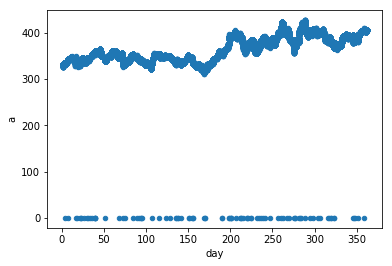

In [15]:
df.plot(x='day',y='a',kind='scatter')

In [16]:
df_clean[df_clean['f'].isnull()]['f']
df_clean.iloc[97110:97323]

,day,timestr,a,b,c,d,e,f
97110,359,14:52:00,408.150,5.565,46.065,46.365,42.13,10.895
97111,359,14:53:00,408.180,5.465,46.080,46.355,42.09,10.895
97112,359,14:54:00,408.035,5.465,46.060,46.345,42.11,10.895
97113,359,14:55:00,408.095,5.465,46.075,46.355,42.06,10.895
97114,359,14:56:00,408.065,5.565,46.057,46.345,42.06,10.895
97115,359,14:57:00,408.140,5.565,46.055,46.345,42.02,10.895
97116,359,14:58:00,408.010,5.565,46.025,46.325,41.94,10.895
97117,359,14:59:00,408.085,5.455,46.028,46.325,41.98,10.895
97118,359,15:00:00,408.250,5.465,46.063,46.325,41.95,10.895
97119,359,15:01:00,408.080,5.465,46.030,46.315,41.95,10.895


In [17]:
list('abcdef')

['a', 'b', 'c', 'd', 'e', 'f']

In our time series forecasting, we will test 1) univariate approaches as well as 2) multivariate approaches, in case there is cross-correlation between data sets. It seems likely, given that $a$ and $d$ in particular show spurious values at the same time points.